In [1]:
import time
import numpy as np
import pandas as pd

from Case import *
pd.set_option('display.max_columns',None)
mimic = pd.read_csv("/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Data preproc/mimic_df_cp.csv.gz", compression='gzip')
eicu = pd.read_csv("/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Data preproc/eicu_df_cp.csv.gz", compression='gzip')

mimic_v1, eicu_v1 = filter_cohort(mimic, eicu) # 코호트의 모든 기록이 no_circ 인 경우 제외

mimic_v2 = define_ambcirc(mimic_v1, 'mimic') # circ - amb - circ -> circ - amb_circ - circ
eicu_v2 = define_ambcirc(eicu_v1, 'eicu')

mimic_v3 = early_event_prediction_label(mimic_v2) # case 1, case 2 정의
eicu_v3 = early_event_prediction_label(eicu_v2)

mimic_v4 = optimized_recovered_labeler(mimic_v3, 'mimic') # case 3, case 4 정의
eicu_v4 = optimized_recovered_labeler(eicu_v3, 'eicu')

mimic_v5 = mimic_v4[~(mimic_v4['classes']=='undefined')]
eicu_v5 = eicu_v4[~(eicu_v4['classes']=='undefined')]

100%|██████████| 9980/9980 [08:53<00:00, 18.71it/s]


In [2]:
invalid_columns_mimic, _ = find_invalid_columns(mimic_v5)
invalid_columns_eicu, _ = find_invalid_columns(eicu_v5)

mimic_v6 = replace_inf_with_previous(mimic_v5, invalid_columns_mimic)
eicu_v6 = replace_inf_with_previous(eicu_v5, invalid_columns_eicu)

In [3]:
mimic_v7 = del_noise(mimic_v6, 'mimic')
eicu_v7 = del_noise(eicu_v6, 'eicu')

step1 모든 관측치가 amb ,0, 0인 stay 제거
step1 완료
step2 forward fill 잔재 제거(특정 시점부터 마지막까지 모두 amb-0-0인 경우)
step2 완료
step1 모든 관측치가 amb ,0, 0인 stay 제거
step1 완료
step2 forward fill 잔재 제거(특정 시점부터 마지막까지 모두 amb-0-0인 경우)
step2 완료


In [4]:
def print_summary(dataset, dataset_name, stay_id_col, patient_id_col):
    print(f'{dataset_name} CACE DEFINED\n')
    print(f'전체 샘플의 개수: {len(dataset)}\n')
    print('샘플의 클래스 개수:')
    print(dataset['classes'].value_counts().sort_index())
    print(f'\n총 Stay 수: {len(dataset[stay_id_col].unique())}')
    print(f'\n총 환자 수: {len(dataset[patient_id_col].unique())}\n')

print_summary(mimic_v7, 'MIMIC-IV', 'stay_id', 'subject_id')

print_summary(eicu_v7, 'eICU', 'patientunitstayid', 'uniquepid')

MIMIC-IV CACE DEFINED

전체 샘플의 개수: 1082578

샘플의 클래스 개수:
1    867612
2     20552
3     23228
4     14468
5    130392
6     26326
Name: classes, dtype: int64

총 Stay 수: 10289

총 환자 수: 9880

eICU CACE DEFINED

전체 샘플의 개수: 1330573

샘플의 클래스 개수:
1    1111101
2      26513
3      14908
4       7207
5     113921
6      56923
Name: classes, dtype: int64

총 Stay 수: 9980

총 환자 수: 9554



In [9]:
sample = mimic_v7[mimic_v7['stay_id']==mimic_v7.stay_id.unique()[7]]
sample[['Time_since_ICU_admission', 'MAP', 'Lactate', 'vasoactive/inotropic', 'Annotation', 'Shock_next_12h', 'classes']]

,Time_since_ICU_admission,MAP,Lactate,vasoactive/inotropic,Annotation,Shock_next_12h,classes
485,0,91.666667,1.1,0,no_circ,1.0,2
486,1,91.666667,1.1,0,no_circ,1.0,2
487,2,91.666667,1.1,0,no_circ,1.0,2
488,3,91.666667,2.3,0,no_circ,1.0,2
489,4,80.000000,2.3,1,circ,1.0,4
490,5,71.833333,2.3,0,circ,1.0,4
491,6,74.000000,2.3,0,ambiguous,1.0,1
492,7,63.666667,2.3,0,ambiguous,1.0,1
493,8,75.333333,2.3,0,ambiguous,1.0,1
494,9,77.047619,2.3,0,ambiguous,1.0,1


In [51]:
mimic_v7[mimic_v7['classes']==1].Annotation.value_counts()

ambiguous    67670
no_circ      25929
Name: Annotation, dtype: int64

In [52]:
sample = mimic_v7[mimic_v7['classes']==1]

amb_case2 = sample[sample['Annotation']=='ambiguous']
nocirc_case2 = sample[sample['Annotation']=='no_circ']

In [53]:
df1 = amb_case2[['MAP', 'Lactate', 'vasoactive/inotropic']]

In [54]:
df2 = nocirc_case2[['MAP', 'Lactate', 'vasoactive/inotropic']]

C:\Users\DAHS\AppData\Local\Temp\ipykernel_15388\7024689.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1['MAP'], label='amb case 2 - MAP', shade=True)
C:\Users\DAHS\AppData\Local\Temp\ipykernel_15388\7024689.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2['MAP'], label='no circ case 2 - MAP', shade=True)


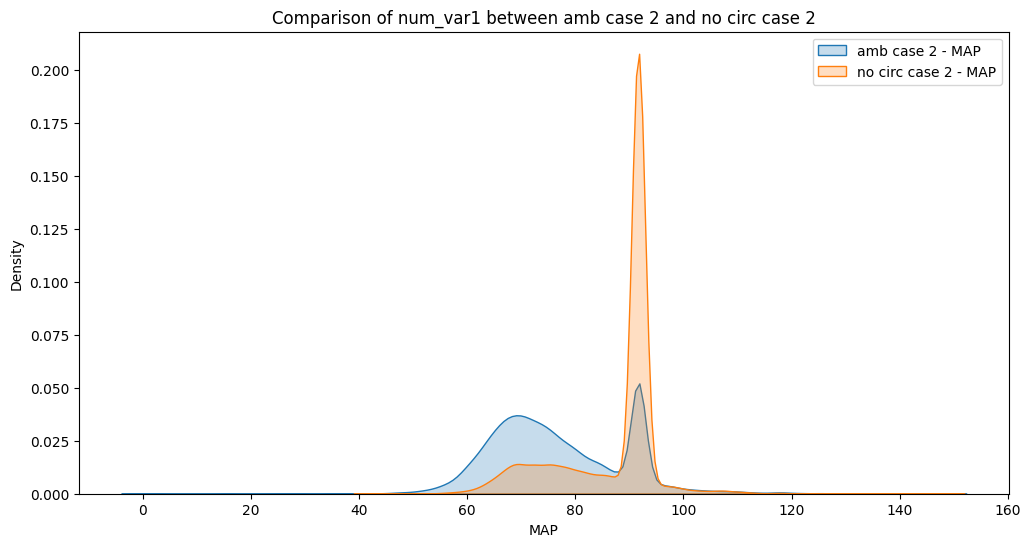

C:\Users\DAHS\AppData\Local\Temp\ipykernel_15388\7024689.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1['Lactate'], label='amb case 2 - Lactate', shade=True)
C:\Users\DAHS\AppData\Local\Temp\ipykernel_15388\7024689.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2['Lactate'], label='no circ case 2 - Lactate', shade=True)


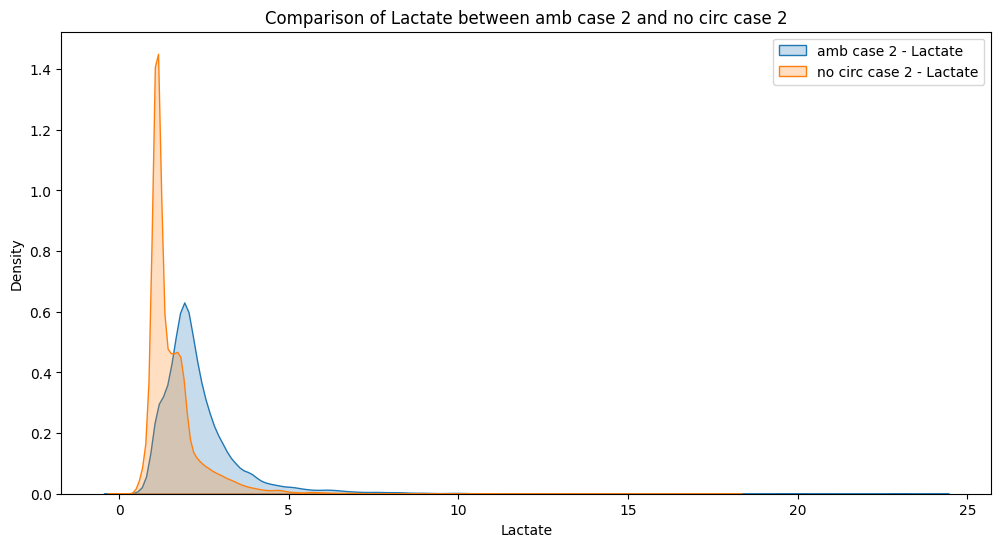

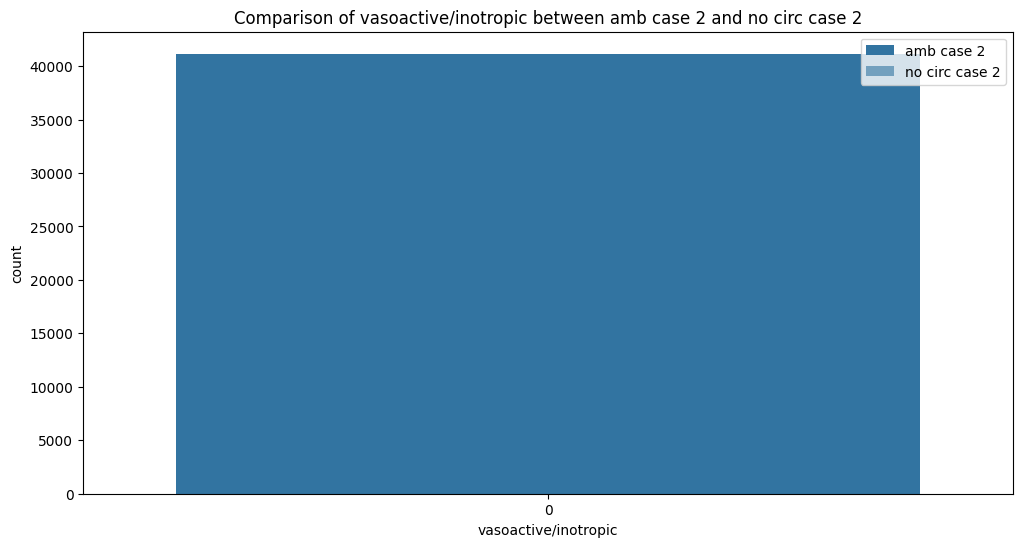

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.kdeplot(df1['MAP'], label='amb case 2 - MAP', shade=True)
sns.kdeplot(df2['MAP'], label='no circ case 2 - MAP', shade=True)
plt.title('Comparison of num_var1 between amb case 2 and no circ case 2')
plt.legend()
plt.show()

# 수치형 변수 2에 대한 비교
plt.figure(figsize=(12, 6))
sns.kdeplot(df1['Lactate'], label='amb case 2 - Lactate', shade=True)
sns.kdeplot(df2['Lactate'], label='no circ case 2 - Lactate', shade=True)
plt.title('Comparison of Lactate between amb case 2 and no circ case 2')
plt.legend()
plt.show()

# 바이너리 변수에 대한 비교
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x='vasoactive/inotropic', data=df1, ax=ax, label='amb case 2')
sns.countplot(x='vasoactive/inotropic', data=df2, ax=ax, label='no circ case 2', alpha=0.6)
plt.title('Comparison of vasoactive/inotropic between amb case 2 and no circ case 2')
ax.legend()
plt.show()


In [56]:
sample = mimic_v7[mimic_v7['classes']==0]

amb_case1 = sample[sample['Annotation']=='ambiguous']
nocirc_case1 = sample[sample['Annotation']=='no_circ']

In [58]:
df1 = amb_case1[['MAP', 'Lactate', 'vasoactive/inotropic']]
df2 = nocirc_case1[['MAP', 'Lactate', 'vasoactive/inotropic']]

C:\Users\DAHS\AppData\Local\Temp\ipykernel_15388\16603076.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1['MAP'], label='amb case 1 - MAP', shade=True)
C:\Users\DAHS\AppData\Local\Temp\ipykernel_15388\16603076.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2['MAP'], label='no circ case 1 - MAP', shade=True)


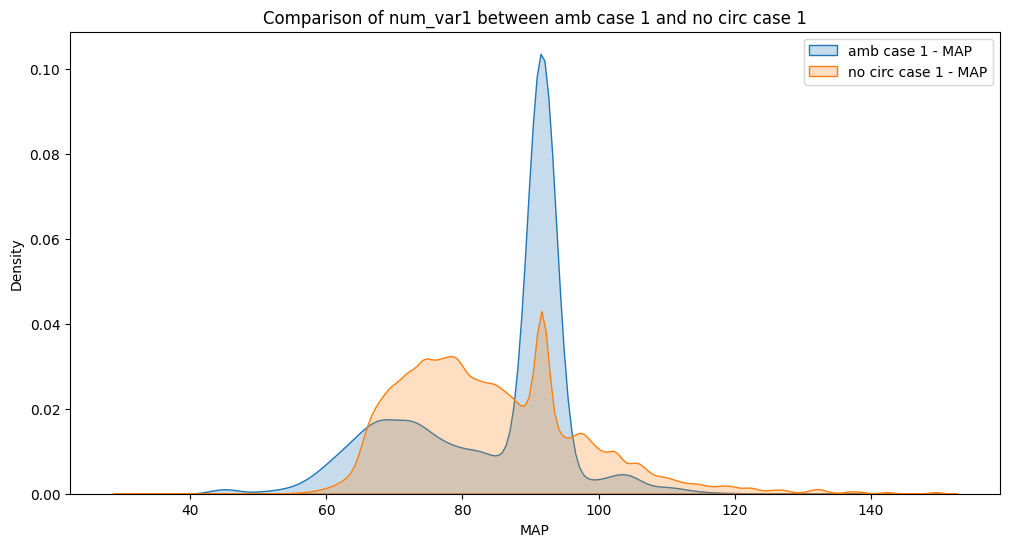

C:\Users\DAHS\AppData\Local\Temp\ipykernel_15388\16603076.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1['Lactate'], label='amb case 1 - Lactate', shade=True)
C:\Users\DAHS\AppData\Local\Temp\ipykernel_15388\16603076.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2['Lactate'], label='no circ case 1 - Lactate', shade=True)


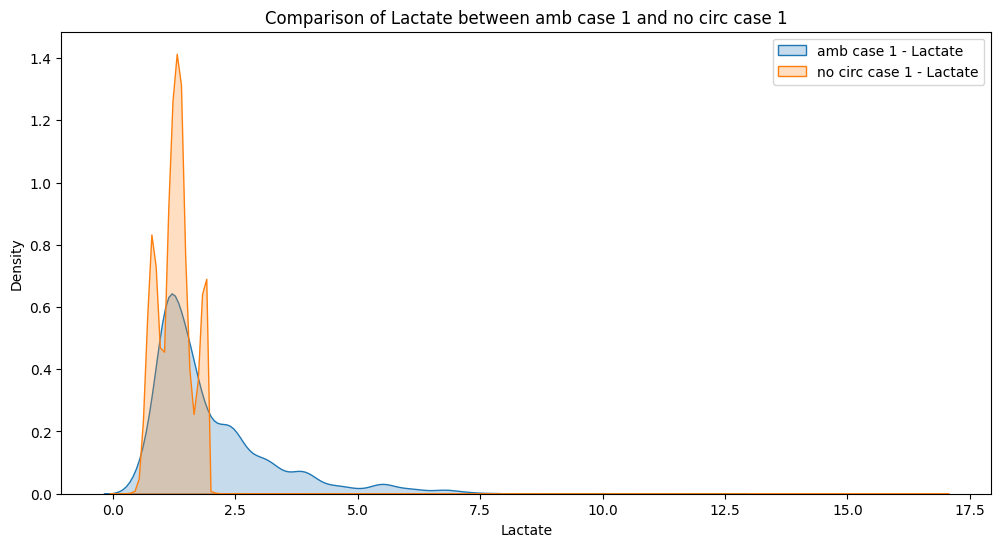

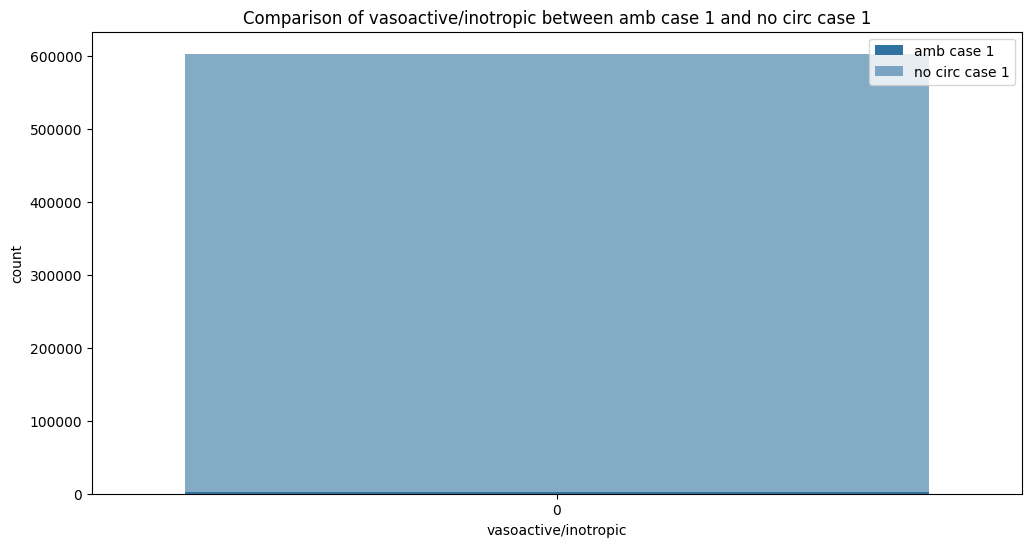

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.kdeplot(df1['MAP'], label='amb case 1 - MAP', shade=True)
sns.kdeplot(df2['MAP'], label='no circ case 1 - MAP', shade=True)
plt.title('Comparison of num_var1 between amb case 1 and no circ case 1')
plt.legend()
plt.show()

# 수치형 변수 2에 대한 비교
plt.figure(figsize=(12, 6))
sns.kdeplot(df1['Lactate'], label='amb case 1 - Lactate', shade=True)
sns.kdeplot(df2['Lactate'], label='no circ case 1 - Lactate', shade=True)
plt.title('Comparison of Lactate between amb case 1 and no circ case 1')
plt.legend()
plt.show()

# 바이너리 변수에 대한 비교
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x='vasoactive/inotropic', data=df1, ax=ax, label='amb case 1')
sns.countplot(x='vasoactive/inotropic', data=df2, ax=ax, label='no circ case 1', alpha=0.6)
plt.title('Comparison of vasoactive/inotropic between amb case 1 and no circ case 1')
ax.legend()
plt.show()

MIMIC-IV CACE DEFINED

전체 샘플의 개수: 915281

샘플의 클래스 개수:
0    609301
1     93599
2     23602
3    188779
Name: classes, dtype: int64

총 Stay 수: 7773

총 환자 수: 7503

eICU CACE DEFINED

전체 샘플의 개수: 617185

샘플의 클래스 개수:
0    378398
1    107409
2      9049
3    122329
Name: classes, dtype: int64

총 Stay 수: 4772

총 환자 수: 4659



In [ ]:
MIMIC-IV CACE DEFINED

전체 샘플의 개수: 927484

샘플의 클래스 개수:
classes
0    612058
1     59562
2     16989
3    238875
Name: count, dtype: int64

총 Stay 수: 8883

총 환자 수: 8546

eICU CACE DEFINED

전체 샘플의 개수: 569246

샘플의 클래스 개수:
classes
0    378172
1     46104
2      6186
3    138784
Name: count, dtype: int64

총 Stay 수: 5208

총 환자 수: 5075

In [5]:
mimic_v7.drop(['Unnamed: 0'], axis = 1).to_csv('MIMIC-IV.csv.gz', index=False, compression='gzip')
eicu_v7.drop(['Unnamed: 0'], axis = 1).to_csv('eICU.csv.gz', index=False, compression='gzip')